In [1]:
import wandb
wandb.login(key="39ded67ba2685c0f85010b40d27298a712244e64")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Preethi\_netrc
wandb: Currently logged in as: mm21b051 (mm21b051-iitmaana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
wandb.init(project="DeepLearning1", name="GradientDescent")

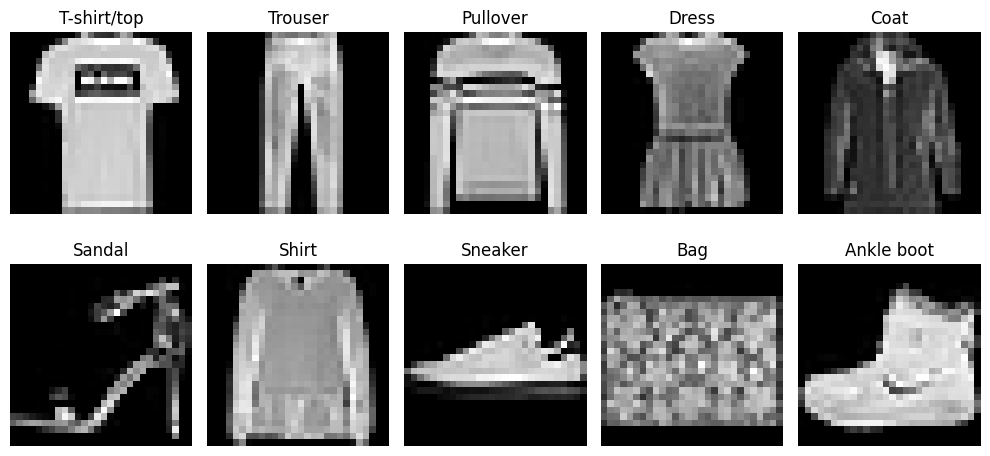

In [3]:
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Defining class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

sample_images = []
sample_labels = []

for class_id in range(10):
    index = np.where(y_train == class_id)[0][0]  # Get the first occurrence of the class
    sample_images.append(x_train[index])
    sample_labels.append(class_names[class_id])

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title(sample_labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

# Feed Forward 

In [4]:
import numpy as np
import pandas as pd
import wandb

x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)  # Flatten

# One-hot encoding labels
num_classes = 10
y_train_onehot = np.eye(num_classes)[y_train]
y_test_onehot = np.eye(num_classes)[y_test]

# Neural Network Class
class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size):
        """
        Initialize the neural network with given architecture.
        :param input_size: Number of input features
        :param hidden_layers: List where each element is the number of neurons in a hidden layer
        :param output_size: Number of output classes
        """
        self.layers = [input_size] + hidden_layers + [output_size]
        self.weights = {}
        self.biases = {}

        # Initialize weights and biases
        for i in range(len(self.layers) - 1):
            self.weights[i] = np.random.randn(self.layers[i], self.layers[i+1]) * 0.01
            self.biases[i] = np.zeros((1, self.layers[i+1]))

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return (Z > 0).astype(float)

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def forward(self, X):
        """
        Forward propagation.
        :param X: Input data
        :return: Activations for each layer
        """
        activations = {0: X}
        for i in range(len(self.layers) - 2):
            Z = np.dot(activations[i], self.weights[i]) + self.biases[i]
            activations[i + 1] = self.relu(Z)
        Z_out = np.dot(activations[len(self.layers) - 2], self.weights[len(self.layers) - 2]) + self.biases[len(self.layers) - 2]
        activations[len(self.layers) - 1] = self.softmax(Z_out)
        return activations

    def backward(self, X, Y, activations, learning_rate):
        """
        Backpropagation algorithm.
        :param X: Input data
        :param Y: True labels
        :param activations: Forward pass activations
        :param learning_rate: Step size for gradient descent
        """
        grads = {}
        m = X.shape[0]
        L = len(self.layers) - 1

        # Compute output layer gradient
        dZ = activations[L] - Y
        grads['dW' + str(L - 1)] = np.dot(activations[L - 1].T, dZ) / m
        grads['db' + str(L - 1)] = np.sum(dZ, axis=0, keepdims=True) / m

        # Backpropagate through hidden layers
        for i in range(L - 2, -1, -1):
            dZ = np.dot(dZ, self.weights[i + 1].T) * self.relu_derivative(activations[i + 1])
            grads['dW' + str(i)] = np.dot(activations[i].T, dZ) / m
            grads['db' + str(i)] = np.sum(dZ, axis=0, keepdims=True) / m

        # Update weights and biases
        for i in range(L):
            self.weights[i] -= learning_rate * grads['dW' + str(i)]
            self.biases[i] -= learning_rate * grads['db' + str(i)]

    def compute_loss(self, Y_true, Y_pred):
        """
        Compute cross-entropy loss.
        """
        m = Y_true.shape[0]
        return -np.sum(Y_true * np.log(Y_pred + 1e-8)) / m

    def train(self, X, Y, epochs=50, batch_size=64, learning_rate=0.01):
        """
        Train the model using mini-batch gradient descent.
        """
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled, Y_shuffled = X[indices], Y[indices]

            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                Y_batch = Y_shuffled[i:i + batch_size]
                activations = self.forward(X_batch)
                self.backward(X_batch, Y_batch, activations, learning_rate)

            # # Log loss to wandb every 10 epochs
            # if epoch % 10 == 0:
            Y_pred = self.forward(X)[len(self.layers) - 1]
            loss = self.compute_loss(Y, Y_pred)
            wandb.log({"epoch": epoch, "loss": loss})
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        """
        Predict class labels.
        """
        activations = self.forward(X)
        return np.argmax(activations[len(self.layers) - 1], axis=1)

# Create and train the network
nn = NeuralNetwork(input_size=784, hidden_layers=[128, 64], output_size=10)
nn.train(x_train, y_train_onehot, epochs=50, batch_size=64, learning_rate=0.01)

# Evaluation on test set
y_pred = nn.predict(x_test)
accuracy = np.mean(y_pred == y_test)
wandb.log({"Test Accuracy": accuracy})  # Log test accuracy
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 0, Loss: 2.3002
Epoch 1, Loss: 2.0391
Epoch 2, Loss: 1.1643
Epoch 3, Loss: 0.9051
Epoch 4, Loss: 0.8116
Epoch 5, Loss: 0.7714
Epoch 6, Loss: 0.7226
Epoch 7, Loss: 0.6443
Epoch 8, Loss: 0.5907
Epoch 9, Loss: 0.5755
Epoch 10, Loss: 0.5573
Epoch 11, Loss: 0.5495
Epoch 12, Loss: 0.5255
Epoch 13, Loss: 0.5185
Epoch 14, Loss: 0.4896
Epoch 15, Loss: 0.4811
Epoch 16, Loss: 0.4775
Epoch 17, Loss: 0.4624
Epoch 18, Loss: 0.4525
Epoch 19, Loss: 0.4351
Epoch 20, Loss: 0.4274
Epoch 21, Loss: 0.4445
Epoch 22, Loss: 0.4350
Epoch 23, Loss: 0.4144
Epoch 24, Loss: 0.4244
Epoch 25, Loss: 0.3946
Epoch 26, Loss: 0.3981
Epoch 27, Loss: 0.3772
Epoch 28, Loss: 0.3920
Epoch 29, Loss: 0.3846
Epoch 30, Loss: 0.4330
Epoch 31, Loss: 0.3682
Epoch 32, Loss: 0.3620
Epoch 33, Loss: 0.3587
Epoch 34, Loss: 0.3481
Epoch 35, Loss: 0.3487
Epoch 36, Loss: 0.3715
Epoch 37, Loss: 0.3355
Epoch 38, Loss: 0.3353
Epoch 39, Loss: 0.3650
Epoch 40, Loss: 0.3439
Epoch 41, Loss: 0.3298
Epoch 42, Loss: 0.3268
Epoch 43, Loss: 0.325